# Задание 1.1 - Метод К-ближайших соседей (K-neariest neighbor classifier)

В первом задании вы реализуете один из простейших алгоритмов машинного обучения - классификатор на основе метода K-ближайших соседей.
Мы применим его к задачам
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, мы выберем его на основе кросс-валидации (cross-validation).

Наша основная задача - научиться пользоваться numpy и представлять вычисления в векторном виде, а также ознакомиться с основными метриками, важными для задачи классификации.

Перед выполнением задания:
- запустите файл `download_data.sh`, чтобы скачать данные, которые мы будем использовать для тренировки
- установите все необходимые библиотеки, запустив `pip install -r requirements.txt` (если раньше не работали с `pip`, вам сюда - https://pip.pypa.io/en/stable/quickstart/)

Если вы раньше не работали с numpy, вам может помочь tutorial. Например этот:  
http://cs231n.github.io/python-numpy-tutorial/

In [117]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
from dataset import load_svhn
from knn import KNN
from metrics import binary_classification_metrics, multiclass_accuracy

# Загрузим и визуализируем данные

В задании уже дана функция `load_svhn`, загружающая данные с диска. Она возвращает данные для тренировки и для тестирования как numpy arrays.

Мы будем использовать цифры из датасета Street View House Numbers (SVHN, http://ufldl.stanford.edu/housenumbers/), чтобы решать задачу хоть сколько-нибудь сложнее MNIST.

In [119]:
train_X, train_y, test_X, test_y = load_svhn("data", max_train=1000, max_test=100)
print train_y


[1 1 7 9 0 3 7 8 1 1 6 6 5 4 3 2 2 7 0 3 8 4 3 9 2 2 9 7 4 1 3 1 9 6 8 8 6
 6 9 1 1 3 2 9 1 9 8 8 1 5 0 2 4 7 2 3 6 1 2 2 3 1 8 3 6 7 1 2 1 9 8 2 1 3
 0 0 1 2 3 2 3 0 1 0 1 3 1 1 2 7 8 5 1 6 9 9 8 4 7 0 4 1 2 5 3 3 1 4 3 5 5
 0 2 4 1 9 7 8 2 3 1 1 0 1 1 2 2 0 5 3 5 4 1 1 7 7 1 3 8 1 3 7 2 9 6 0 5 4
 5 2 6 3 2 1 1 2 9 0 7 6 5 3 3 1 2 3 9 8 5 0 5 1 7 2 5 2 2 0 0 3 2 1 0 6 2
 1 7 5 2 7 3 7 9 6 8 3 4 1 1 2 1 0 8 3 9 1 6 6 3 4 6 9 6 6 2 2 1 9 9 2 4 7
 2 7 5 1 9 6 4 6 2 8 6 4 5 3 6 7 1 9 8 6 1 9 2 3 7 5 7 8 2 6 9 9 3 9 6 1 4
 7 5 0 2 8 4 7 4 1 8 8 1 7 2 1 0 1 1 1 4 6 4 2 0 1 2 2 3 3 1 1 7 2 6 7 0 3
 7 4 2 5 1 0 9 6 8 3 6 1 6 2 1 4 2 1 9 4 6 1 4 8 3 3 1 2 4 7 4 8 3 9 8 2 2
 7 5 4 4 7 6 1 6 4 5 6 9 7 1 5 0 3 1 3 4 4 2 7 2 9 2 8 1 1 7 9 1 9 2 2 4 9
 2 2 7 2 4 0 9 1 1 3 0 3 2 0 2 1 5 8 5 2 3 4 4 2 1 5 2 2 6 2 2 3 3 1 8 3 8
 1 2 8 3 3 2 5 3 4 2 4 2 7 4 2 3 9 3 2 8 3 6 2 7 4 1 3 1 3 2 3 6 9 2 3 9 1
 8 9 4 2 1 1 2 6 8 4 2 3 3 2 4 1 2 4 8 9 1 7 1 3 1 5 6 9 1 6 2 3 5 0 0 4 0
 7 4 1 1 4 5 0 3 4 2 2 6 

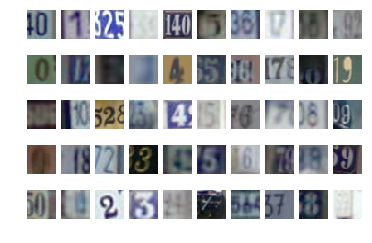

In [120]:
samples_per_class = 5  # Number of samples per class to visualize
num_of_digits = 10
plot_index = 1
for example_index in range(samples_per_class):
    for class_index in range(num_of_digits):        
        plt.subplot(samples_per_class, num_of_digits, plot_index)
        image = train_X[train_y == class_index][example_index]
        plt.imshow(image.astype(np.uint8))
        plt.axis('off')    
        plot_index += 1

##### Сначала реализуем KNN для бинарной классификации

В качестве задачи бинарной классификации мы натренируем модель, которая будет отличать цифру 0 от цифры 9.

In [121]:
# First, let's prepare the labels and the source data

# Only select 0s and 9s
binary_train_mask = (train_y == 0) | (train_y == 9)
binary_train_X = train_X[binary_train_mask]
binary_train_y = train_y[binary_train_mask] == 0

binary_test_mask = (test_y == 0) | (test_y == 9)
binary_test_X = test_X[binary_test_mask]
print np.shape(binary_test_X)
binary_test_y = test_y[binary_test_mask] == 0

# Reshape to 1-dimensional array [num_samples, 32*32*3]
binary_train_X = binary_train_X.reshape(binary_train_X.shape[0], -1)
binary_test_X = binary_test_X.reshape(binary_test_X.shape[0], -1)


(11L, 32L, 32L, 3L)


In [122]:
# Create the classifier and call fit to train the model
# KNN just remembers all the data
knn_classifier = KNN(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

## Пришло время написать код! 

Последовательно реализуйте функции `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops`
в файле `knn.py`.

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание** Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)).

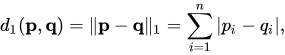

In [123]:
# TODO: implement compute_distances_two_loops in knn.py
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
print dists
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))

[[138750. 116854.  89194. ... 141573. 125414. 132294.]
 [ 95994. 101920. 139698. ...  97807. 133410. 193820.]
 [165151. 123645.  55623. ... 142022. 134223. 141013.]
 ...
 [186262. 241384. 314298. ... 196357. 254938. 325452.]
 [158307. 172041. 149211. ... 162292. 156295. 130625.]
 [259141. 191021. 116189. ... 231334. 197889. 180423.]]


In [124]:
a = np.array([[1,2,3],[2,3,4]])
b = [1,1,1]
c = abs(a - b)
print(c)
print(np.sum(c, axis=1))
# TODO: implement compute_distances_one_loop in knn.py
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
print dists
print np.shape(dists)
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))


[[0 1 2]
 [1 2 3]]
[3 6]
[[138750. 116854.  89194. ... 141573. 125414. 132294.]
 [ 95994. 101920. 139698. ...  97807. 133410. 193820.]
 [165151. 123645.  55623. ... 142022. 134223. 141013.]
 ...
 [186262. 241384. 314298. ... 196357. 254938. 325452.]
 [158307. 172041. 149211. ... 162292. 156295. 130625.]
 [259141. 191021. 116189. ... 231334. 197889. 180423.]]
(11L, 135L)


In [125]:
a = np.array([[1,2,3,4],[2,3,4,5],[2,3,4,5],[2,3,4,5],[2,3,4,5],[2,3,4,5],[2,3,4,5]])
b = np.array([[1,1,1,1],[2,2,2,2]])
c = np.zeros((b.shape[0], a.shape[0]), np.float32)
print c
print np.shape(a)

d = abs(a[:,:,None] - b.T[None,:,:])
print np.shape(d)
print d
print "Result", np.sum(d, axis=1).T


print np.shape(binary_train_X)
print np.shape(binary_test_X)

# TODO: implement compute_distances_no_loops in knn.py
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
print(np.shape(dists))
print dists
assert np.isclose(dists[0, 10], np.sum(np.abs(binary_test_X[0] - binary_train_X[10])))


[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
(7L, 4L)
(7L, 4L, 2L)
[[[0 1]
  [1 0]
  [2 1]
  [3 2]]

 [[1 0]
  [2 1]
  [3 2]
  [4 3]]

 [[1 0]
  [2 1]
  [3 2]
  [4 3]]

 [[1 0]
  [2 1]
  [3 2]
  [4 3]]

 [[1 0]
  [2 1]
  [3 2]
  [4 3]]

 [[1 0]
  [2 1]
  [3 2]
  [4 3]]

 [[1 0]
  [2 1]
  [3 2]
  [4 3]]]
Result [[ 6 10 10 10 10 10 10]
 [ 4  6  6  6  6  6  6]]
(135L, 3072L)
(11L, 3072L)
(11L, 135L)
[[138750. 116854.  89194. ... 141573. 125414. 132294.]
 [ 95994. 101920. 139698. ...  97807. 133410. 193820.]
 [165151. 123645.  55623. ... 142022. 134223. 141013.]
 ...
 [186262. 241384. 314298. ... 196357. 254938. 325452.]
 [158307. 172041. 149211. ... 162292. 156295. 130625.]
 [259141. 191021. 116189. ... 231334. 197889. 180423.]]


In [126]:
# Lets look at the performance difference
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

10 loops, best of 3: 22.5 ms per loop
10 loops, best of 3: 27.4 ms per loop
10 loops, best of 3: 28.8 ms per loop


In [127]:
# TODO: implement predict_labels_binary in knn.py
print ">", binary_test_X, np.shape(binary_test_X)

print ">", binary_train_X, np.shape(binary_train_X)
prediction = knn_classifier.predict(binary_test_X)
print prediction

> [[ 90. 109. 139. ...  99. 123. 151.]
 [152. 155. 160. ... 145. 149. 148.]
 [ 77.  72.  66. ...  73.  69.  70.]
 ...
 [242. 227. 188. ... 243. 229. 190.]
 [ 31.  48.  99. ... 111. 114. 102.]
 [ 85.  81.  72. ... 133. 112.  91.]] (11L, 3072L)
> [[137. 139. 138. ... 138. 140. 139.]
 [127. 152. 152. ... 108. 114. 104.]
 [ 92. 118.  90. ...  95. 119.  95.]
 ...
 [158. 151. 133. ... 153. 143. 124.]
 [149. 123.  37. ...  34.  54.  99.]
 [ 37.  50.  67. ...  65.  68.  75.]] (135L, 3072L)
[ True  True  True False  True  True  True False False False False]


In [128]:
# TODO: implement binary_classification_metrics in metrics.py
precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("KNN with k = %s" % knn_classifier.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

KNN with k = 1
Accuracy: 0.27, Precision: 0.33, Recall: 0.33, F1: 0.33


In [129]:
# Let's put everything together and run KNN with k=3 and see how we do
knn_classifier_3 = KNN(k=3)
knn_classifier_3.fit(binary_train_X, binary_train_y)
prediction = knn_classifier_3.predict(binary_test_X)

precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("KNN with k = %s" % knn_classifier_3.k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

KNN with k = 3
Accuracy: 0.36, Precision: 0.50, Recall: 0.43, F1: 0.46


In [130]:
a = [[1,2,3]]
print np.append(a, [[2,3,4]], axis=0)
     

[[1 2 3]
 [2 3 4]]


# Кросс-валидация (cross-validation)

Попробуем найти лучшее значение k! 

Для этого мы воспользуемся k-fold cross-validation (https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation). Мы разделим тренировочные данные на 5 фолдов (folds), и по очереди будем использовать каждый из них в качестве проверочных данных (validation data), а остальные -- в качестве тренировочных (training data).

В качестве финальной оценки эффективности k мы усредним значения F1 score на всех фолдах.
После этого мы просто выберем значение k с лучшим значением метрики.

*Бонус*: есть ли другие варианты агрегировать F1 score по всем фолдам? Напишите плюсы и минусы в клетке ниже.

In [131]:
# Find the best k using cross-validation based on F1 score
num_folds = 5
train_folds_X = []
train_folds_y = []

for i in range(0, num_folds):
    part_num = binary_train_X.shape[0] / num_folds
    train_folds_X.append(binary_train_X[i*part_num:i*part_num + part_num])
    train_folds_y.append(binary_train_y[i*part_num:i*part_num + part_num])

# TODO: split the training data in 5 folds and store them in train_folds_X/train_folds_y

k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]
k_to_f1 = {}  # dict mapping k values to mean F1 scores (int -> float)

for k in k_choices:
    # TODO: perform cross-validation
    # Go through every fold and use it for testing and all other folds for training
    # Perform training and produce F1 score metric on the validation dataset
    # Average F1 from all the folds and write it into k_to_f1
    knn_classifier_4 = KNN(k=k)
    
    for i in range(0, num_folds):        
        part_train_X = np.append(binary_train_X[0:i*part_num], binary_train_X[i*part_num + part_num:binary_train_X.shape[0]], axis=0)
        part_train_y = np.append(binary_train_y[0:i*part_num], binary_train_y[i*part_num + part_num:binary_train_y.shape[0]], axis=0)
        
        # print part_train_X.shape, part_train_X
        # continue
        
        part_test_X = binary_train_X[i*part_num:i*part_num + part_num]
        part_test_y = binary_train_y[i*part_num:i*part_num + part_num]
        knn_classifier_4.fit(part_train_X, part_train_y)

        prediction = knn_classifier_4.predict(part_test_X)    
        precision, recall, f1, accuracy = binary_classification_metrics(prediction, part_test_y)
        
        k_to_f1[k] = f1
    pass

for k in sorted(k_to_f1):
    print('k = %d, f1 = %f' % (k, k_to_f1[k]))

0
1
2
3
4
k = 1, f1 = 0.451613
k = 2, f1 = 0.529412
k = 3, f1 = 0.428571
k = 5, f1 = 0.551724
k = 8, f1 = 0.588235
k = 10, f1 = 0.562500
k = 15, f1 = 0.551724
k = 20, f1 = 0.545455
k = 25, f1 = 0.545455
k = 50, f1 = 0.540541


### Проверим, как хорошо работает лучшее значение k на тестовых данных (test data)

In [132]:
# TODO Set the best k to the best value found by cross-validation
best_k = 2

best_knn_classifier = KNN(k=best_k)
best_knn_classifier.fit(binary_train_X, binary_train_y)
prediction = best_knn_classifier.predict(binary_test_X)

precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)
print("Best KNN with k = %s" % best_k)
print("Accuracy: %4.2f, Precision: %4.2f, Recall: %4.2f, F1: %4.2f" % (accuracy, precision, recall, f1)) 

Best KNN with k = 2
Accuracy: 0.36, Precision: 0.67, Recall: 0.44, F1: 0.53


# Многоклассовая классификация (multi-class classification)

Переходим к следующему этапу - классификации на каждую цифру.

In [133]:
# Now let's use all 10 classes
train_X = train_X.reshape(train_X.shape[0], -1)
test_X = test_X.reshape(test_X.shape[0], -1)

knn_classifier = KNN(k=1)
knn_classifier.fit(train_X, train_y)

In [135]:
# TODO: Implement predict_labels_multiclass
predict = knn_classifier.predict(test_X)

In [139]:
# TODO: Implement multiclass_accuracy
accuracy = multiclass_accuracy(predict, test_y)
print("Accuracy: %4.2f" % accuracy)

Accuracy: 0.50


Снова кросс-валидация. Теперь нашей основной метрикой стала точность (accuracy), и ее мы тоже будем усреднять по всем фолдам.

In [140]:
# Find the best k using cross-validation based on F1 score
num_folds = 5
train_folds_X = []
train_folds_y = []

for i in range(0, num_folds):
    part_num = binary_train_X.shape[0] / num_folds
    train_folds_X.append(train_X[i*part_num:i*part_num + part_num])
    train_folds_y.append(train_y[i*part_num:i*part_num + part_num])

# TODO: split the training data in 5 folds and store them in train_folds_X/train_folds_y

k_choices = [1, 2, 3, 5, 8, 10, 15, 20, 25, 50]
k_to_accuracy = {}  # dict mapping k values to mean F1 scores (int -> float)

for k in k_choices:
    # TODO: perform cross-validation
    # Go through every fold and use it for testing and all other folds for training
    # Perform training and produce F1 score metric on the validation dataset
    # Average F1 from all the folds and write it into k_to_f1
    knn_classifier_4 = KNN(k=k)
    
    for i in range(0, num_folds):        
        part_train_X = np.append(train_X[0:i*part_num], train_X[i*part_num + part_num:train_X.shape[0]], axis=0)
        part_train_y = np.append(train_y[0:i*part_num], train_y[i*part_num + part_num:train_y.shape[0]], axis=0)
        
        # print part_train_X.shape, part_train_X
        # continue
        
        part_test_X = train_X[i*part_num:i*part_num + part_num]
        part_test_y = train_y[i*part_num:i*part_num + part_num]
        knn_classifier_4.fit(part_train_X, part_train_y)

        prediction = knn_classifier_4.predict(part_test_X)    
        accuracy = multiclass_accuracy(prediction, part_test_y)
        
        k_to_accuracy[k] = accuracy
    pass

for k in sorted(k_to_accuracy):
    print('k = %d, accuracy = %f' % (k, k_to_accuracy[k]))


0
1
2
3
4
k = 1, accuracy = 0.500000
k = 2, accuracy = 0.500000
k = 3, accuracy = 0.500000
k = 5, accuracy = 0.500000
k = 8, accuracy = 0.500000
k = 10, accuracy = 0.500000
k = 15, accuracy = 0.500000
k = 20, accuracy = 0.500000
k = 25, accuracy = 0.500000
k = 50, accuracy = 0.500000


### Финальный тест - классификация на 10 классов на тестовой выборке (test data)

Если все реализовано правильно, вы должны увидеть точность не менее **0.2**.

In [141]:
# TODO Set the best k as a best from computed
best_k = 1

best_knn_classifier = KNN(k=best_k)
best_knn_classifier.fit(train_X, train_y)
prediction = best_knn_classifier.predict(test_X)

# Accuracy should be around 20%!
accuracy = multiclass_accuracy(prediction, test_y)
print("Accuracy: %4.2f" % accuracy)

Accuracy: 0.50
